# **HW3**

In [1]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 

# 3개의 기업 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()

# 기간 설정
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [3]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [4]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS  # 연평균수익률
cov_mat = returns_df.cov() * N_DAYS

In [5]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:,np.newaxis]

In [6]:
portf_rtns = np.dot(weights,avg_returns)

portf_vol = []
for i in range(0, len(weights)): 
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                  np.dot(cov_mat, weights[i]))))


portf_vol = np.array(portf_vol)  # 행렬로 변환
portf_sharpe_ratio = portf_rtns / portf_vol  # 샤프 비율 계산하기

In [7]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

portf_results_df 

,returns,volatility,sharpe_ratio
0,-0.041840,0.229741,-0.182118
1,-0.032099,0.250964,-0.127903
2,-0.052787,0.232481,-0.227058
3,0.101937,0.262019,0.389045
4,-0.038378,0.251882,-0.152366
...,...,...,...
99995,0.061836,0.245998,0.251370
99996,0.049962,0.250287,0.199618
99997,-0.048928,0.229516,-0.213178
99998,0.050206,0.256901,0.195430


In [8]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

### **Maximum Sharpe ratio portfolio**

In [9]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

### **Minimum variance portfolio weights**

In [10]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

# **HW4**

In [11]:
import numpy as np
import scipy.optimize as sco

In [12]:
N_DAYS = 252

returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [13]:
def get_portf_rtn(w, ave_rtns):
    return np.sum(ave_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [14]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for assets in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess,
                                           args = args, method = 'SLSQP',
                                           constraints = constraints,
                                           bounds = bounds)
        efficient_portfolios.append(efficient_portfolio)
        
    return efficient_portfolios

In [15]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [16]:
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [17]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [18]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': -0.1250251256281407,
 'Volatility': 0.22580473027744621,
 'Sharpe Ratio': -0.5536869199973019}

In [19]:
max_rtn_ind = np.argmax(rtns_range)
max_rtn_portf_vol = vols_range[max_rtn_ind]
max_rtn_portf_rtn = efficient_portfolios[max_rtn_ind]['fun']

max_rtn_portf = {'Return': max_rtn_portf_rtn,
                 'Volatility': max_rtn_portf_vol,
                 'Sharpe Ratio': (max_rtn_portf_rtn /
                                  max_rtn_portf_vol)}

In [20]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

In [21]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})   
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess,  
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [22]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.21458111034107336,
 'Volatility': 0.2835380616507977,
 'Sharpe Ratio': 0.7567982552033845}

In [23]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

In [24]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [25]:
adj_close = df['Adj Close']
returns = returns = adj_close.pct_change().dropna()

train = returns['2018-01-01':'2018-06-30']
test = returns['2018-07-01':'2018-12-31']

In [26]:
T = 1
N = len(returns_df)
N_SIM = 10**3

In [27]:
returns_df

,AAPL,IBM,MSFT
Date,,,
2018-01-03,-0.000174,0.027488,0.004654
2018-01-04,0.004645,0.020254,0.008801
2018-01-05,0.011385,0.004885,0.012398
2018-01-08,-0.003714,0.006031,0.001021
2018-01-09,-0.000115,0.002203,-0.000680
...,...,...,...
2018-12-21,-0.038896,-0.018404,-0.032312
2018-12-24,-0.025874,-0.030377,-0.041739
2018-12-26,0.070422,0.035512,0.068310


In [28]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    np.random.seed(random_seed)                                                 # 시뮬레이션 식 정의하는 코드 강조    

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)    #cum = cumulative (누적해서 더하는 것) , axis = 0 이 의미하는 것은 세로로 더하는 것 axis = 1이 의미하는 것은 가로로 더하는 것

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)                                        ### 행렬 S_t에 인덱스 0인 자리에 s_0 삽입

    return S_t           

**Simulation 1 : minimizing the volatility** 

In [29]:
shares = efficient_portfolios[min_vol_ind]['x']
shares

array([0.28038243, 0.58980027, 0.12981731])

In [30]:
mu = np.matmul(avg_returns, shares)
sigma = np.matmul(np.matmul(shares, cov_mat.values), shares.T)
print(mu)
print(sigma)

-0.12502512563538554
0.05098777621567024


In [31]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)
gbm_simulations

array([[1.        , 1.00109827, 1.00014358, ..., 0.87619231, 0.87390111,
        0.8784548 ],
       [1.        , 1.00080158, 0.99622687, ..., 0.90507908, 0.9015932 ,
        0.90058186],
       [1.        , 0.99666892, 0.99172235, ..., 0.83836677, 0.83597885,
        0.83605924],
       ...,
       [1.        , 1.00197953, 1.00694425, ..., 0.88839654, 0.88780322,
        0.89128989],
       [1.        , 0.99754596, 0.99509607, ..., 0.88062026, 0.88144008,
        0.87680829],
       [1.        , 0.9933521 , 0.99824732, ..., 0.92887668, 0.93043501,
        0.93339884]])

In [32]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))
gbm_simulations_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001098,1.000802,0.996669,0.997056,1.005315,0.995548,1.004486,1.003252,1.003340,1.001382,...,1.006975,0.998988,0.994905,0.998912,1.003659,1.003412,1.000029,1.001980,0.997546,0.993352
2,1.000144,0.996227,0.991722,0.994583,1.006888,0.995152,1.010505,0.999743,1.005129,1.007286,...,1.003956,0.999666,0.996007,1.004148,1.000777,1.002884,1.000490,1.006944,0.995096,0.998247
3,1.001731,0.998679,0.994190,0.989571,1.004522,0.992176,1.016743,1.000006,1.005760,1.001700,...,1.002853,0.997347,0.996946,1.005131,0.998063,1.004866,1.001014,1.011290,0.999563,0.995444
4,1.006162,1.005041,0.999836,0.986123,1.005872,0.992422,1.020203,1.002653,1.008732,1.006437,...,0.997500,0.997489,0.995304,1.005403,0.997786,1.000693,1.002850,1.011399,0.995623,0.989818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.879379,0.899981,0.837745,0.972213,0.991980,0.921288,0.943353,0.883843,0.855298,0.906745,...,0.814126,0.877108,0.881166,0.876700,0.801545,0.819294,0.853787,0.893446,0.878671,0.933855
246,0.877983,0.903963,0.837390,0.970944,0.990825,0.919180,0.948100,0.881566,0.852234,0.905152,...,0.815984,0.871594,0.881804,0.876961,0.796726,0.815544,0.856690,0.892563,0.879825,0.930506
247,0.876192,0.905079,0.838367,0.968315,0.988463,0.926339,0.947300,0.882349,0.850682,0.904560,...,0.813845,0.869152,0.879536,0.877384,0.795026,0.818280,0.854482,0.888397,0.880620,0.928877
248,0.873901,0.901593,0.835979,0.964697,0.984728,0.924183,0.946303,0.884186,0.852138,0.904176,...,0.815856,0.863947,0.878924,0.872820,0.795494,0.820323,0.853868,0.887803,0.881440,0.930435


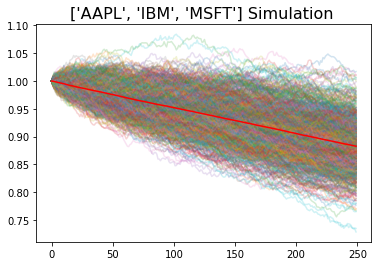

In [33]:
import matplotlib.pyplot as plt

plot_title = (f'{RISKY_ASSETS} Simulation ')

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(gbm_simulations_df.mean(axis=1),
                  color='red')

ax.set_title(plot_title, fontsize=16)

plt.show()

**Simulation2 : maximizing the returns(sharp ratio)**

In [34]:
shares = max_sharpe_portf_w
shares

array([1.66533454e-16, 0.00000000e+00, 1.00000000e+00])

In [36]:
mu = np.matmul(avg_returns, shares)
sigma = np.matmul(np.matmul(shares, cov_mat.values), shares.T)

In [37]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)
gbm_simulations

array([[1.        , 1.00338515, 1.00353002, ..., 1.21998264, 1.21696113,
        1.22899925],
       [1.        , 1.00291632, 0.99734052, ..., 1.28400039, 1.27831754,
        1.27816295],
       [1.        , 0.99639425, 0.99023945, ..., 1.13798115, 1.13474401,
        1.13678875],
       ...,
       [1.        , 1.00477819, 1.01431019, ..., 1.24688304, 1.24762559,
        1.25743142],
       [1.        , 0.99777708, 0.99555615, ..., 1.22971787, 1.23355552,
        1.22536914],
       [1.        , 0.99117099, 1.00053164, ..., 1.33763398, 1.34338702,
        1.35236829]])

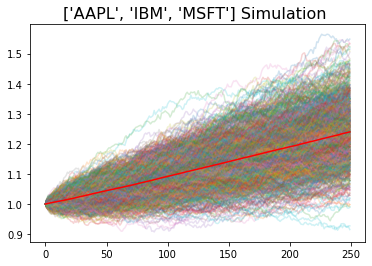

In [39]:
plot_title = (f'{RISKY_ASSETS} Simulation ')
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(gbm_simulations_df.mean(axis=1),
                  color='red')

ax.set_title(plot_title, fontsize=16)
plt.show()